In [1]:
from PIL import Image
import kraken
from kraken import binarization
from kraken import blla
from kraken import serialization
from kraken.lib import vgsl
import os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from IPython.display import clear_output
import time 
import pickle

# 2024-10-25 19:42:03.146647: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

In [3]:
pwd

'/home/natalkaser/mmp/Potanin/strokes_cut'

In [4]:
!python --version

Python 3.8.20


In [5]:
!which python

/home/natalkaser/mmp/Potanin/strokes_cut/env3.8/bin/python


In [6]:
!pip install kraken

In [6]:
# filename = 'datasets/litke/valid/images/1_6.png'
filename = '../КККМ/КККМ ОФ 7928:19 Анучин В.jpeg'
# filename = '../КККМ_bin/КККМ ОФ 7928:19 Анучин В.png'

In [7]:
model_path = 'blla.mlmodel'
model = vgsl.TorchVGSLModel.load_model(model_path)

In [8]:
img = Image.open(filename)
bw = binarization.nlbin(img)

In [9]:
# baseline_seg = blla.segment(bw, model=model, device='cuda')
baseline_seg = blla.segment(bw, model=model, device='cpu')

In [10]:
baseline_seg.lines

[BaselineLine(id='d1c1927e-51c5-4219-998d-49d64f25cd6e', baseline=[[56, 113], [63, 113]], boundary=[[56, 113], [57, 118], [63, 115], [63, 113], [60, 91], [55, 93], [56, 113]], text=None, base_dir=None, type='baselines', imagename=None, tags={'type': 'default'}, split=None, regions=['a42a05df-65f0-494f-8a17-09ad5dcc5d05']),
 BaselineLine(id='11edf36a-c5bb-4d0b-ba51-f30bce02385d', baseline=[[342, 70], [495, 68]], boundary=[[475, 43], [471, 43], [460, 53], [439, 53], [418, 40], [417, 40], [417, 40], [416, 40], [416, 40], [408, 46], [402, 41], [402, 40], [402, 40], [401, 40], [393, 40], [392, 40], [392, 40], [382, 45], [379, 42], [379, 41], [378, 41], [378, 41], [363, 41], [362, 41], [362, 41], [361, 41], [361, 41], [349, 54], [343, 54], [341, 59], [342, 70], [342, 72], [345, 75], [345, 76], [345, 76], [345, 76], [346, 76], [361, 75], [361, 75], [361, 75], [361, 74], [364, 72], [379, 74], [379, 74], [393, 72], [402, 72], [405, 75], [405, 75], [406, 75], [406, 75], [407, 75], [407, 75], [41

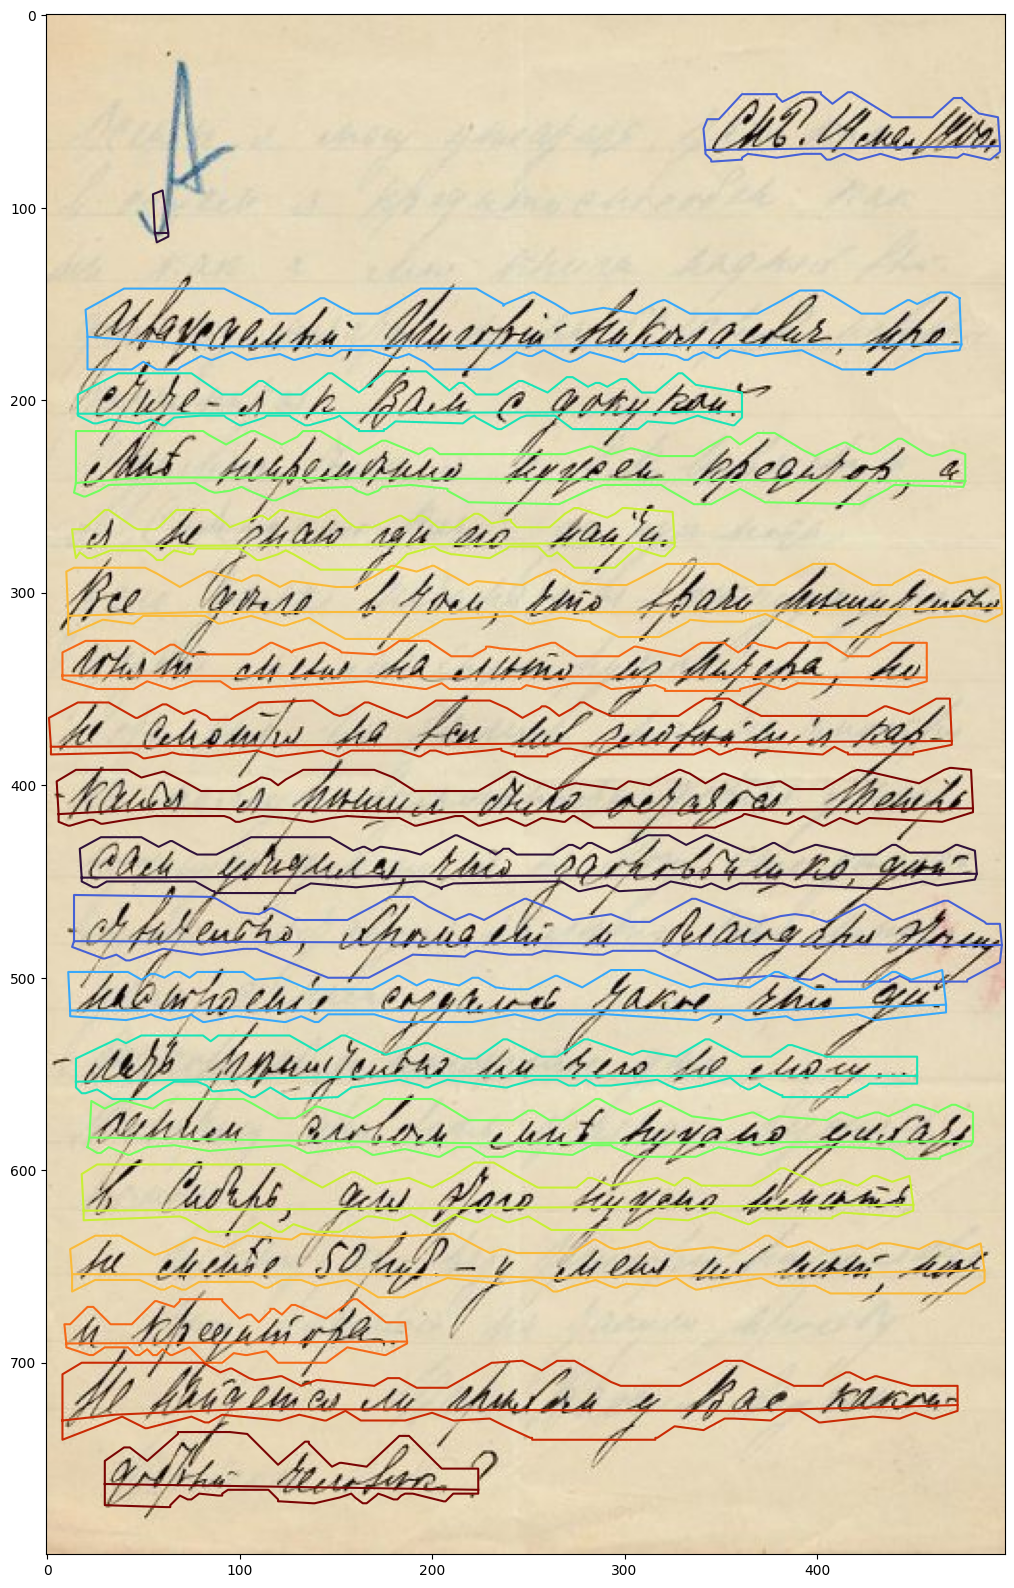

In [17]:
from matplotlib.colors import to_hex
from matplotlib import colormaps

colormap = colormaps['turbo']
colors = [to_hex(c) for c in colormap(np.linspace(0, 1, 10))] * (len(baseline_seg.lines) // 10 + 1)

plt.figure(figsize=(20,20))
plt.imshow(img)

baselines = [line.baseline for line in baseline_seg.lines]
boundaries = [line.boundary for line in baseline_seg.lines]

for i in range(len(baselines)):
    # plt.plot(list(zip(*baseline)), color=colors[i], marker='o')
    # # color = plt.gca().lines[-1].get_color()
    # plt.plot(list(zip(*boundary)), color=colors[i])

    baseline = baselines[i]
    boundary = boundaries[i]

    plt.plot([b[0] for b in baseline], [b[1] for b in baseline], color=colors[i])
    plt.plot([b[0] for b in boundary], [b[1] for b in boundary], color=colors[i])

name = "p.pdf"
plt.savefig(name, bbox_inches='tight')
plt.show()

In [51]:
baseline_seg.lines[-1].baseline

[[30, 763], [224, 766]]

# Обработка датасета

In [2]:
from matplotlib.colors import to_hex
from matplotlib import colormaps


def save_data(data, path):
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_data(path):
    with open(path, "rb") as f:
        data = pickle.load(f)

    return data


def recur_paths(dir):
    ans = []
    
    for img in os.listdir(dir):
        x = os.path.join(dir, img)
        if os.path.isdir(x):
            ans.extend(recur_paths(x))
        else:
            ans.append(x)
    return ans


def recur_mkdir(dir):
    path = dir.split("/")

    if "." in path[-1]:
        path = path[:-1]

    for i in range(len(path)):
        cur_dir = "/".join(path[:i+1])
        # if "." in cur_dir:
        #     continue
        
        if not os.path.exists(cur_dir):
            !mkdir "$cur_dir"
            # print(f"mkdir {cur_dir}")


def change_ext(path, ext):
    return os.path.splitext(path)[0] + ext


model_path = 'blla.mlmodel'
model = vgsl.TorchVGSLModel.load_model(model_path)

colormap = colormaps['turbo']


def ext_lines(filename, new_path, path_pickle):
    global model, colormap

    img = Image.open(filename)
    bw = binarization.nlbin(img)
    baseline_seg = blla.segment(bw, model=model, device='cpu')

    baselines = [line.baseline for line in baseline_seg.lines]
    boundaries = [line.boundary for line in baseline_seg.lines]

    data = {"baselines" : baselines, "boundaries" : boundaries}

    save_data(data, path_pickle)

    plt.figure(figsize=(20, 20))
    plt.imshow(img)

    colors = [to_hex(c) for c in colormap(np.linspace(0, 1, 10))] * (len(baselines) // 10 + 1)

    for i in range(len(baselines)):
        baseline = baselines[i]
        boundary = boundaries[i]

        plt.plot([b[0] for b in baseline], [b[1] for b in baseline], color=colors[i])
        plt.plot([b[0] for b in boundary], [b[1] for b in boundary], color=colors[i])

    plt.savefig(new_path, bbox_inches='tight')
    # plt.show()

In [3]:
FOLDER = "../КККМ"
NEW_FOLDER = "КККМ_lines"
FILES_FOLDER = "КККМ_pickles"

for path in tqdm(recur_paths(FOLDER)):
    print(f"---   {path}   ---")

    split_path = path.split("/")

    new_path = [NEW_FOLDER] + split_path[1:]
    new_path = "/".join(new_path)
    new_path = change_ext(new_path, ".pdf")

    # new_path = img + "_lines" + ext
    path_pickle = [NEW_FOLDER] + split_path[1:2] + [FILES_FOLDER] + split_path[2:]
    path_pickle = "/".join(path_pickle)
    path_pickle = change_ext(path_pickle, ".pickle")
    # new_path, path_pickle

    recur_mkdir(f"../{new_path}")
    recur_mkdir(f"../{path_pickle}")

    ext_lines(path, f"../{new_path}", f"../{path_pickle}")

    # clear_output()

# new_path, path_pickle


  0%|          | 0/2654 [00:00<?, ?it/s]

---   ../КККМ/КККМ ОФ 7928:1770 Крутовский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1975 Мендельсон.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1601 Вагнер.jpeg   ---


Polygonizer failed on line 0: index 0 is out of bounds for axis 0 with size 0


---   ../КККМ/КККМ ОФ 7928:453 Жане.jpeg   ---


TopologyException: side location conflict at 459.24324324324323 932. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 891.83698296836985 889.68369829683695. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 640.12780577187357 892.15712322491981. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 319.05911713688982 1180.2072993734291. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 363 1371.5862068965516. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely 

---   ../КККМ/КККМ ОФ 7928:1670 Колпинский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2352 Андреев.jpeg   ---


Polygonizer failed on line 0: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


---   ../КККМ/КККМ ОФ 7928:2275 Черепанова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2258 Тыжнов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2286 Шерстообев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1235 Фарафонтова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2183 Руднев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:973 Семидалов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:281 Виноградов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:883 Окулич.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:660 Лаврский К.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2235 Тимашев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1967 Макушин А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2375 Гребенщиков и Ильинский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1731 Красноженова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1591 Иванчин-Писарев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:684 Лаврский А.jpeg   ---


/tmp/ipykernel_77264/3716535984.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


---   ../КККМ/КККМ ОФ 7928:2081 Пирожков.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Self-intersection[451.709146272697 243.264125408819]


---   ../КККМ/КККМ ОФ 7928:888 Ольденбург.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1332 Янчук.jpeg   ---


TopologyException: side location conflict at 1100.1156626506024 1167.922891566265. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
Polygonizer failed on line 0: Invalid bounding polygon computed: Self-intersection[738.68455460883 1532.06054221534]
TopologyException: side location conflict at 1098.2022630834513 1151.022630834512. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:678 Лаврский В.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1282 Федченко.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:52 Адрианов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2397 Сапожников.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:47.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:37.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:38.jpeg   ---
---   ../КККМ/Письма Потанина/Проскурякову КККМ ОФ 8400:70.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:48.jpeg   ---
---   ../КККМ/Письма Потанина/Зубашевой КККМ ОФ 7928:12.jpeg   ---
---   ../КККМ/Письма Потанина/Потаниной КККМ ОФ 7928:13.jpeg   ---
---   ../КККМ/Письма Потанина/Проскурякову КККМ ОФ 8400:10.jpeg   ---
---   ../КККМ/Письма Потанина/Грудинину КККМ ОФ 7928:14.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:43.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:44.jpeg   ---
---   ../КККМ/Пись

Polygonizer failed on line 0: Invalid bounding polygon computed: Self-intersection[519.962643364282 300.950737302021]


---   ../КККМ/Письма Потанина/Зубашеву КККМ ОФ 7928:10.jpeg   ---
---   ../КККМ/Письма Потанина/Колосову КККМ ОФ 13233:8.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:41.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:39.jpeg   ---
---   ../КККМ/Письма Потанина/Редакция газеты КККМ ОФ 7928:5.jpeg   ---
---   ../КККМ/Письма Потанина/Макерову КККМ ОФ 7928:9.jpeg   ---
---   ../КККМ/Письма Потанина/Неизвестному КККМ ОФ 7928:16.jpeg   ---
---   ../КККМ/Письма Потанина/Окуличу КККМ ОФ 7928:11.jpeg   ---
---   ../КККМ/Письма Потанина/Красноженовой КККМ ОФ 13020:46.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2144 Ржавская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:215 Бабанина.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1605 Вейнберг.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:693 Леонтович В.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:918 Попов И.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1424 Козьмин.jpeg   ---


Polygonizer failed on line 0: index 0 is out of bounds for axis 0 with size 0


---   ../КККМ/КККМ ОФ 7928:857 Новомбергская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1999 Никифоров Н.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1024 Сукачевы.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:775 Мендельсон.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2648 Гейер.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2828.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1789 Крутовский.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Ring Self-intersection[2388 657]


---   ../КККМ/КККМ ОФ 7928:1745 Коншин.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1744 Коншин.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:151 Барановская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2043 Пронников.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1313 Эггерс.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:724 Леонович.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:819 Максимович.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1608 Веселовский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:468 Зубашева.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1436 Совет народного образования.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1880 Клич.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2006 Окулич.jpeg   ---


TopologyException: side location conflict at 391.03846153846155 1166.0461538461539. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 378.0982800982801 1249.490171990172. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1005.5 1792. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:2054 Педашенко А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1334 Ярилов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1014 Сапожников.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2056 Певцов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1986 Мартьянов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:478 Цезарская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2100 Пыпин.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:376 Головачев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1606 Вейнберги.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:575 Кузнецова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2073 Проскурякова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:491 Заостровская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1206 Тихонравова Р.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2294 Шостакович Б.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1189 Смирнова М.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1500 Балакшины.jpeg   ---


TopologyException: side location conflict at 1347.0820985182218 1014.042851421706. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1052.7142857142858 1347.7142857142858. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 843.74074074074076 436.74074074074076. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1394 1273.8. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1208.5 1207. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created

---   ../КККМ/КККМ ОФ 7928:1936 Михайлов К.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1952 Макаренко.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2808 Тиблен.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:171 Боголюбская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2197 Стукачева.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Self-intersection[617.838372817955 133.370168329177]


---   ../КККМ/КККМ ОФ 7928:1636 Гуркин Г.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Self-intersection[421.287040618956 1708.01392649903]


---   ../КККМ/КККМ ОФ 7928:190 Булгаков.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:978 Семидалов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:751 Лонгиновский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:425 Вознесенский А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1913 Миклашевская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1409 Андреев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2293 Шостакович.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2794 Тихонравова Р.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1976 Мендельсон.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1979 Мендельсон.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1283 Федченко.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:552 Иванова-Микулина.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:243 Васенев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1536 Лаптев, Коншин.jpeg   ---


Polygonizer failed on line 0: index 1 is out of bounds for axis 0 with size 0
Polygonizer failed on line 0: index 1 is out of bounds for axis 0 with size 0
Polygonizer failed on line 0: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
TopologyException: side location conflict at 560.61702127659578 1679.0372340425531. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 905.17241379310349 1671. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:2272 Чурофин.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1006 Сементовская М.jpeg   ---


TopologyException: side location conflict at 1063.6725663716813 1459.9380530973451. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1130.3783783783783 591.45945945945948. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:2098 Пыпина.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:518 Ивановский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1969 Макушин П.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2689 Потанина А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:342 Ганейзер.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:704 Лесевич В.jpeg   ---


TopologyException: side location conflict at 777.86711772665763 820.03599458728013. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:2741 Козлова Е.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2113 Пантелеев.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1718 Коржинский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:647 Потанина А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1930 Муромов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:536 Ивановский.jpeg   ---


TopologyException: side location conflict at 1099 1624. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:2823 Яковлева.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2066 Проскурякова.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:2378 Пругавин.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:150 Барановская.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:638 Лаврская А.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:539 Ивановский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:403 Горячкина.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1524 Участники Сибирского обеда.jpeg   ---


TopologyException: side location conflict at 1444.5544013121926 785.96500820120286. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1981.4606017191977 1125.2707736389684. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 243.13543296374397 971.2724304469084. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 311.29658399625646 1137.5326158165653. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1907.6857142857143 1115. This can occur if the input geometry is invalid.
Polygonizer failed on line

---   ../КККМ/КККМ ОФ 7928:1814 Крутовский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1977 Мендельсон.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1633 Гуркин Г.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1867 Костюрина.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:481 Цезарская.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Ring Self-intersection[1475 765]


---   ../КККМ/КККМ ОФ 7928:1032 Солдатов.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1008 Сементовская В.jpeg   ---


Polygonizer failed on line 0: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
TopologyException: side location conflict at 1085.4581005586592 39.74860335195531. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value
TopologyException: side location conflict at 1107.5006858710562 602.0013717421125. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:1645 Банзаров.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:989 Семидалов.jpeg   ---


Polygonizer failed on line 0: Invalid bounding polygon computed: Ring Self-intersection[1016 168]


---   ../КККМ/КККМ ОФ 7928:1980 Маковецкая.jpeg   ---


Polygonizer failed on line 0: index 0 is out of bounds for axis 1 with size 0


---   ../КККМ/КККМ ОФ 7928:1060 Серошевский.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1889 Личков.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1659 Зубашева.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:411 Гурари.jpeg   ---
---   ../КККМ/КККМ ОФ 7928:1093 Соболев М.jpeg   ---


TopologyException: side location conflict at 815.39235412474852 910.47786720321926. This can occur if the input geometry is invalid.
Polygonizer failed on line 0: No Shapely geometry can be created from null value


---   ../КККМ/КККМ ОФ 7928:1100 Свентицкая.jpeg   ---


: 

: 

: 

In [22]:


for i in range(10):
    clear_output()
    print("Hello World!")
    time.sleep(1)

Hello World!


In [18]:
path

'../КККМ/КККМ ОФ 7928:1975 Мендельсон.jpeg'